In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from pandas.io.json import json_normalize
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn.metrics import mean_squared_error
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from matplotlib.pylab import rcParams

## Comprehensive Model Functions

These functions will make modeling the NFT collection of your choice a quick and easy process. 

#### Data Collection - Opensea API

In [20]:
#From Opensea, find the URL's tag associated with the collection, and insert into function as a string 
#Example: https://opensea.io/collection/mutantcats would insert "mutantcats" into this function
def pull_opensea_events(collection_name):

    events_list = []
    for i in range(0,10000,50):
        url = f"https://api.opensea.io/api/v1/events?only_opensea=true&collection_slug={collection_name}&occurred_before=2021-12-02T22:32:47.007226"
        querystring = {"offset":f"{i}","limit":"50", 'event_type': 'successful'}
        headers = {"X-API-KEY": "YOUR-API-KEY-HERE"}
        response = requests.request("GET", url, headers=headers, params=querystring)
        json = response.json()
        df = json_normalize(json['asset_events'])
        events_list.append(df)
        print(f"Total {i} observations and {len(df)} observations added")
    collection_data = pd.concat([df for df in events_list], ignore_index=True, sort=False)
    print("")
    return collection_data

#### Data Extraction and Preparation

In [21]:
#convert the dataframe to a datetime index
def opensea_to_dt(df): 
    df["created_date"] = pd.to_datetime(df["created_date"])
    df2 = df.set_index(df["created_date"])
    return df2

#convert prices to ETH figures
def fix_prices(price):
    return price * 9.999999999999999e-19


#function to drop nulls, create clean ETH price column, and drop irrelevant columns
def opensea_df_clean(df):
    df["total_price"].dropna(inplace=True)
    df["total_price"] = pd.to_numeric(df["total_price"], downcast="float", errors="coerce")
    df['total_price_eth'] = df["total_price"].apply(fix_prices)
    df_columns_keep = ["id", "quantity", "total_price_eth", "asset.id", "asset.token_id", "asset.num_sales", 
                   "asset.name", "seller.address", "transaction.block_hash", "transaction.block_number",
                  "transaction.id", "transaction.timestamp", "transaction.transaction_hash", "transaction.transaction_index",
                  "winner_account.address"]
    new_df = df[df_columns_keep]
    return new_df

#### Save to CSV for Modeling

In [22]:
def save_as_csv(df, name):
#Takes in a dataframe and a filename specified by the user(as a string)'''
#Saves dataframe as a CSV file for import and use in other notebooks '''
    df.to_csv(name)
    return print("CSV saved")

#### EDA

In [23]:
#this function imports a dataframe from your machine, turns the index into a datetime, and performs EDA functions
#you need to supply:
#csv_location is a string containing the location where your data is saved, for example: "data/NFTname.csv"
#your_df_name represents the name of the variable you want to save your dataframe to when you call the function
def starter_eda(csv_string):
    
    your_df_name = pd.read_csv(csv_string, index_col=0)
    your_df_name.index = pd.to_datetime(your_df_name.index)
    print("Data overview:")    
    print(your_df_name.describe())
    
    print("Historic sales data:")
    your_df_name["total_price_eth"].plot()
    
    #create datetime visualization columns
    your_df_name["year"] = your_df_name.index.year
    your_df_name["month"] = your_df_name.index.month
    your_df_name["hour"] = your_df_name.index.hour
    your_df_name["weekday"] = your_df_name.index.day_name()
    
    print("Amount of sales occurring on each day of the week:")
    #view sales stats for each day of the week
    weekdays = your_df_name["weekday"].value_counts()
    fig, ax = plt.subplots()
    x = weekdays.index
    y = weekdays
    sns.barplot(x=x, y=y)
    
    print("Amount of sales occurring historically per hour")    
    #view sales stats for each day of the week
    hourcounts = your_df_name["hour"].value_counts()
    fig, ax = plt.subplots()
    x = hourcounts.index
    y = hourcounts
    sns.barplot(x=x, y=y)
    
    return your_df_name

#### Preprocessing

In [25]:
#import a datetime indexed dataframe 
#function will drop any null sales (with 0 eth transaction), resample TS to lowest sale every 4 hours, fill nulls
def prep_to_model(dt):
    dropzero = dt[dt["total_price_eth"] == 0.0]
    dt.drop(dropzero.index, inplace=True)
    ts = dt["total_price_eth"].resample('4H').min()
    ready_ts = ts.bfill()
    return ready_ts 

#### Train and Test Split

In [24]:
#train test split
def tts(ts):
    cutoff = round(ts.shape[0]*0.8)
    train = ts[:cutoff]
    test = ts[cutoff:]
    return train, test

#### ARIMA Grid Search

In [26]:
#insert your time series-ready data
def gridsearch(ts):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p,d,q))
    pdqs = [(x[0], x[1], x[2], 36) for x in list(itertools.product(p, d, q))]

#run all possible combinations, return parameters that provide the best AIC score
    paramlist = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                output = mod.fit()
                paramlist.append([comb, combs, output.aic])
                print('Arima {} x {}36 : AIC score ={}'.format(comb, combs, output.aic))
            except:
                continue
                
    param_df = pd.DataFrame(paramlist, columns=['pdq', 'pdqs', 'aic'])
    order_result = param_df.loc[param_df['aic'].idxmin()][0]
    seasonal_result = param_df.loc[param_df['aic'].idxmin()][1]
    print(param_df.loc[param_df['aic'].idxmin()])
    return order_result, seasonal_result

#make sure to save function as two parameters: order and seasonal, these will be fed into your create_model function next

#### Generate Model

In [27]:
def create_model(ts, order_result, seasonal_result): 
    arima = sm.tsa.statespace.SARIMAX(ts, order=order_result,  
                                      seasonal_order=seasonal_result,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)

    ts_model = arima.fit()
    print(ts_model.summary().tables[1])
    return ts_model

## Modeling: Cool Cats NFT

In [10]:
#import data and generate EDA visualizations

Data overview:
                 id      quantity  total_price_eth      asset.id  \
count  1.000000e+04  10000.000000     10000.000000  9.992000e+03   
mean   8.139559e+08      1.002100         5.195344  3.024108e+07   
std    4.328628e+08      0.107223         5.959583  1.585661e+05   
min    3.845898e+08      1.000000         0.000000  3.009146e+07   
25%    5.012980e+08      1.000000         1.650000  3.022750e+07   
50%    6.725215e+08      1.000000         4.200000  3.023716e+07   
75%    9.711410e+08      1.000000         7.000000  3.024416e+07   
max    2.290254e+09     10.000000       319.999999  3.700270e+07   

       asset.token_id  asset.num_sales  transaction.block_number  \
count     9992.000000      9992.000000              1.000000e+04   
mean      5003.126001         4.695356              1.316303e+07   
std       2829.917378         2.393119              1.886220e+05   
min          6.000000         1.000000              1.294075e+07   
25%       2624.500000         3.

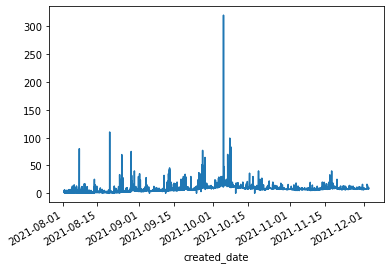

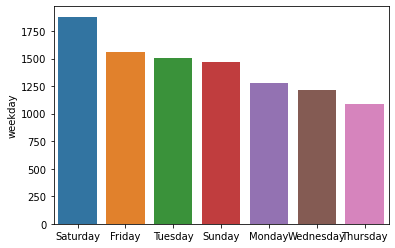

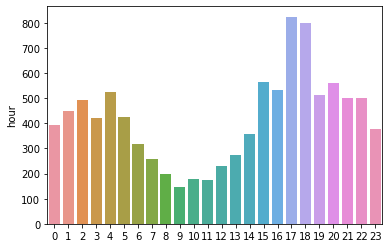

In [30]:
ccnft = starter_eda("cool_cats_new.csv")

In [31]:
ccnft_ts = prep_to_model(ccnft)

In [32]:
train, test = tts(ccnft_ts)

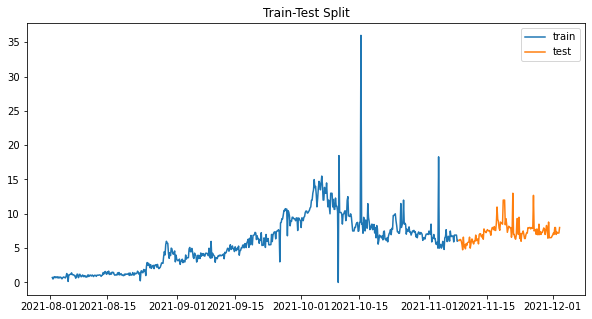

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [34]:
order, seasonal = gridsearch(train)

Arima (0, 0, 0) x (0, 0, 0, 36)36 : AIC score =3937.971188658536
Arima (0, 0, 0) x (0, 0, 1, 36)36 : AIC score =3285.8823143080713
Arima (0, 0, 0) x (0, 1, 0, 36)36 : AIC score =2687.9044597015954
Arima (0, 0, 0) x (0, 1, 1, 36)36 : AIC score =2525.388534706999
Arima (0, 0, 0) x (1, 0, 0, 36)36 : AIC score =2685.7255190234114
Arima (0, 0, 0) x (1, 0, 1, 36)36 : AIC score =2665.9989881309093
Arima (0, 0, 0) x (1, 1, 0, 36)36 : AIC score =2531.445590226287
Arima (0, 0, 0) x (1, 1, 1, 36)36 : AIC score =2528.4151437098244
Arima (0, 0, 1) x (0, 0, 0, 36)36 : AIC score =3440.0201006571165
Arima (0, 0, 1) x (0, 0, 1, 36)36 : AIC score =2997.381391102975
Arima (0, 0, 1) x (0, 1, 0, 36)36 : AIC score =2627.940158328928
Arima (0, 0, 1) x (0, 1, 1, 36)36 : AIC score =2436.9221293128103
Arima (0, 0, 1) x (1, 0, 0, 36)36 : AIC score =2621.313859073073
Arima (0, 0, 1) x (1, 0, 1, 36)36 : AIC score =2574.0836213820166
Arima (0, 0, 1) x (1, 1, 0, 36)36 : AIC score =2453.101421689497
Arima (0, 0, 1) x

In [36]:
cc_model = create_model(train, order, seasonal)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2130      0.022    -55.033      0.000      -1.256      -1.170
ma.S.L36      -1.0000    334.414     -0.003      0.998    -656.439     654.439
sigma2         1.9914    666.033      0.003      0.998   -1303.409    1307.392


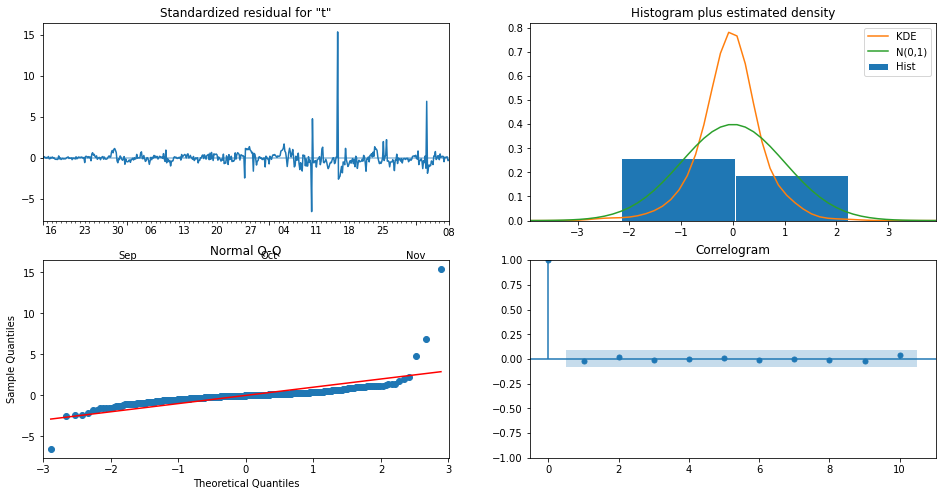

In [37]:
cc_model.plot_diagnostics(figsize=(16,8));

In [38]:
pred = cc_model.get_prediction(start=pd.to_datetime('2021-09-01'), dynamic=False)
pred_conf = pred.conf_int()

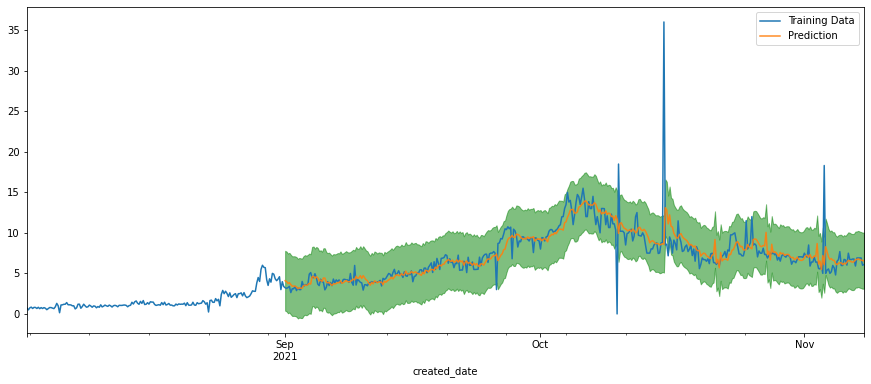

In [39]:
# Plot our real data vs predicted values along with confidence intervals
rcParams['figure.figsize'] = 15, 6
# Plot observed values
ax = train.plot(label='Training Data')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)
plt.legend()
plt.show()

In [40]:
#Get RMSE of predictions from Sept 1 until now
forecasted_values = pred.predicted_mean
true_values = train['2021-09-01':]

np.sqrt(mean_squared_error(true_values, forecasted_values))

1.984724818638718

In [44]:
#gather non-dynamic predictions and confidence intervals
pred = cc_model.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_conf = pred.conf_int()

In [45]:
#Get RMSE of predictions from July until now
forecasted_values = pred.predicted_mean
true_values = train['2021-10-01':]

np.sqrt(mean_squared_error(true_values, forecasted_values))

2.544084771041974

In [47]:
#Create forecast using our model, specify how many periods we want to predict
future = cc_model.get_forecast(steps=300)
# Get confidence intervals of forecasts
future_conf = future.conf_int()

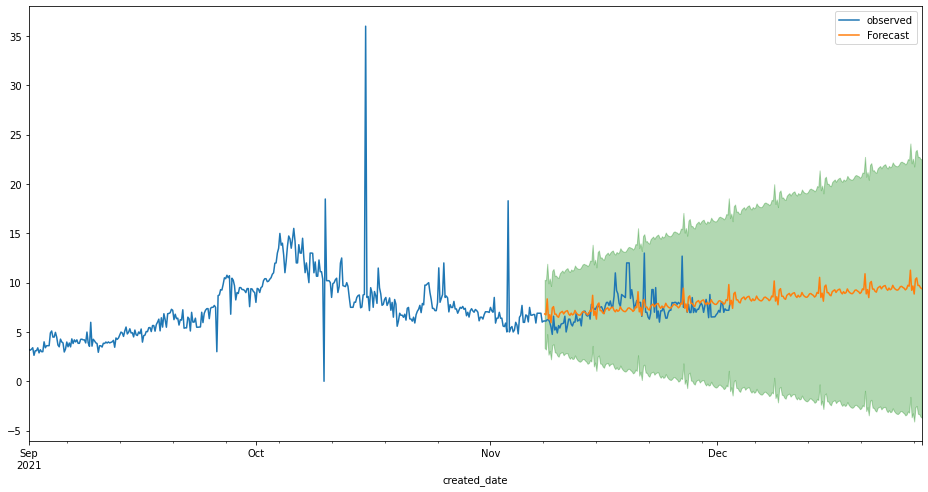

In [50]:
# Plot future predictions with confidence intervals
ax = ccnft_ts["2021-09-01":].plot(label='observed', figsize=(16, 8))
future.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(future_conf.index,
                future_conf.iloc[:, 0],
                future_conf.iloc[:, 1], color='g', alpha=0.3)

plt.legend()
plt.show()

In [52]:
np.sqrt(mean_squared_error(test, future.predicted_mean[:148]))

1.3401809138283096

Today's Floor Price for Cool Cats: 7.5

In [56]:
future.predicted_mean["2021-12-02"]

2021-12-02 00:00:00    7.929027
2021-12-02 04:00:00    8.279944
2021-12-02 08:00:00    8.185511
2021-12-02 12:00:00    9.807694
2021-12-02 16:00:00    7.767920
2021-12-02 20:00:00    8.204894
Freq: 4H, Name: predicted_mean, dtype: float64

In [57]:
#Predictions for Next Week
future.predicted_mean["2021-12-09"]

2021-12-09 00:00:00    7.757242
2021-12-09 04:00:00    9.248732
2021-12-09 08:00:00    9.390707
2021-12-09 12:00:00    8.618784
2021-12-09 16:00:00    8.624099
2021-12-09 20:00:00    8.392832
Freq: 4H, Name: predicted_mean, dtype: float64

The model is suggesting that the price will go up in a week, so our model recommends to invest in Cool Cats for a swing.

In [60]:
from sklearn import metrics

In [62]:
metrics.r2_score(test, future.predicted_mean[:148])

0.03129978403809519

In [67]:
metrics.explained_variance_score(true_values, forecasted_values)

0.35222115676415067

In [65]:
metrics.mean_squared_error(test, future.predicted_mean[:148], squared=False)

1.3401809138283096

In [ ]:
np.sqrt(mean_squared_error(true_values, forecasted_values))

In [66]:
metrics.r2_score(true_values, forecasted_values)

0.3492574333806625